<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Time Series Equities Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import math
import os
from pathlib import Path
path = Path()

We will get the data for this exercise from the TD Ameritrade API.  TDAmeritrade provides a <a href=https://developer.tdameritrade.com/price-history/apis/get/marketdata/%7Bsymbol%7D/pricehistory>'Price History' API</a> which one can query to get daily price history on any listed stock.  To access it one must have register for an API key. If you would like to run this notebook on your own, you must first register as a developer to get your own API key, and then plug it in below.

In [2]:
# Load API key (read this in from a config.py file or type it in)
if os.path.exists('config.py'):
    print('Reading in API key from config file')
    import config
    key = config.api_key
else:
    key = input('Please enter your API key:')

Reading in API key from config file


In [3]:
# Set request parameters
stock = 'GOOG'
frequency = 'daily'
num_years = 10

In [4]:
# Function to make the API request
def make_request(stock,frequency,num_years):
    
    # Set endpoint
    endpoint = f'https://api.tdameritrade.com/v1/marketdata/{stock}/pricehistory'

    # Define API payload
    payload = {
        'apikey': key,
        'periodType':'year',
        'period':num_years,
        'frequencyType':frequency,
        'frequency':1,
        'needExtendedHoursData':False
    }
    
    # Make API request
    response = requests.get(url = endpoint, params=payload)

    # Decode JSON content
    data = response.json()
    
    return data

response = make_request(stock, frequency, num_years)

In [5]:
# Convert the response into a pandas dataframe for further analysis
def convert_data(response):
    
    # Grab only the quotes ('candles'), strip out everything else
    dailyprices = response['candles']

    # Convert from dictionary to a Pandas dataframe to make it easy to work with
    dailyprices = pd.DataFrame.from_dict(dailyprices, orient='columns')
    
    return dailyprices
    
dailyprices = convert_data(response)
dailyprices.head()

,open,high,low,close,volume,datetime
0,18.838801,18.967449,18.763860,18.847545,111452000,1348808400000
1,18.961204,19.109836,18.890261,19.029400,126839640,1349067600000
2,19.114832,19.134566,18.741878,18.909745,111703560,1349154000000
3,18.878020,19.082857,18.790090,19.047386,88415660,1349240400000
4,19.053631,19.231989,18.969947,19.186025,98257740,1349326800000


From the above, we can see that the dates are not in a format that works well for us.  Let's convert to a more readable format and make it the index of the dataframe

In [6]:
def clean_data (raw_data_df):
    
    dailyprices = raw_data_df.copy()
    
    # Convert dates to pandas datetime format
    dailyprices['date']=pd.to_datetime(dailyprices['datetime'],unit='ms') # Since api data is in ms since epoch, use 'ms' here

    # Set index to new 'date' column
    dailyprices.set_index(keys='date',inplace=True)

    # Drop old datetime column
    dailyprices.drop(columns=['datetime'],inplace=True)
    
    return dailyprices

dailyprices = clean_data(dailyprices)
dailyprices.head()

,open,high,low,close,volume
date,,,,,
2012-09-28 05:00:00,18.838801,18.967449,18.763860,18.847545,111452000
2012-10-01 05:00:00,18.961204,19.109836,18.890261,19.029400,126839640
2012-10-02 05:00:00,19.114832,19.134566,18.741878,18.909745,111703560
2012-10-03 05:00:00,18.878020,19.082857,18.790090,19.047386,88415660
2012-10-04 05:00:00,19.053631,19.231989,18.969947,19.186025,98257740


In [7]:
# Set API request parameters
stocks = ['GOOG','DIA'] # Get prices for Google and the Dow Jones index
frequency = 'daily'
num_years = 10

# Set up dictionary to hold results
stockdata = {}

for stock in stocks:
    # Get the price data from API
    dailyprices = make_request(stock,frequency,num_years)
    # Convert api response to pandas dataframe
    dailyprices = convert_data(dailyprices)
    # Clean up the data
    dailyprices = clean_data(dailyprices)
    # Store in dictionary
    stockdata[stock] = dailyprices

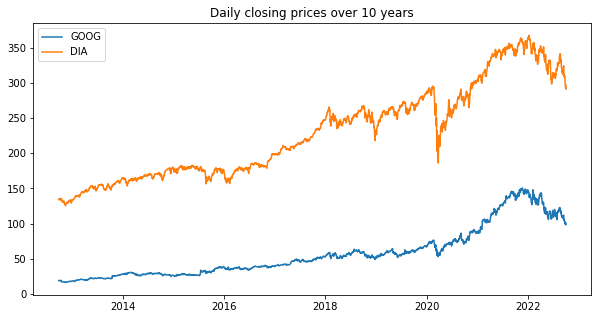

In [8]:
# Now let's plot the closing prices of GOOG versus the market (DIA)
plt.figure(figsize=(10,5))
for stock in stocks:
    plt.plot(stockdata[stock]['close'])
    
plt.title(f'Daily closing prices over {num_years} years') # Add title
plt.legend(labels=[stock for stock in stocks])
plt.show()

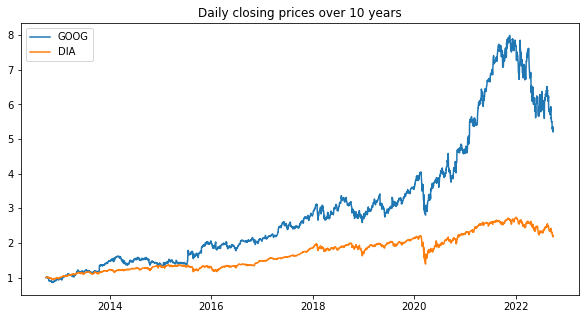

In [9]:
# Let's look at % increase/decrease over time from the starting point baseline

plt.figure(figsize=(10,5))
for stock in stocks:
    normalized = stockdata[stock]['close'] / stockdata[stock]['close'].iloc[0]
    plt.plot(normalized)
    
plt.title(f'Daily closing prices over {num_years} years') # Add title
plt.legend(labels=[stock for stock in stocks])
plt.show()

### Resample a time series

In [10]:
# Let's resample the time series from daily to yearly, using the year-end values

yearend_GOOG = stockdata['GOOG'].asfreq('A',method='ffill')

yearend_GOOG

,open,high,low,close,volume
date,,,,,
2012-12-31 05:00:00,17.528341,17.658738,17.486375,17.486375,56201600
2013-12-31 05:00:00,27.990040,27.990289,27.703517,27.714508,49507600
2014-12-31 05:00:00,26.404500,26.557500,26.356500,26.521000,17478460
2015-12-31 05:00:00,38.830000,38.880000,38.345000,38.550000,25870420
2016-12-31 05:00:00,39.137500,39.139000,38.520500,38.591000,35399000
2017-12-31 05:00:00,52.336000,52.485000,52.245000,52.320000,17750220
2018-12-31 05:00:00,52.481000,52.778000,51.655000,51.854000,28275440
2019-12-31 05:00:00,67.500000,67.650000,66.701000,66.807000,21026460
2020-12-31 05:00:00,88.100500,88.254750,86.280000,86.976000,26122600


In [11]:
# Resample the data, using the mean value for each year rather than the year-end value

# Resample using the mean values for each year
annual_mean_GOOG = stockdata['GOOG'].resample('A').mean()
    
annual_mean_GOOG

,open,high,low,close,volume
date,,,,,
2012-12-31,17.540336,17.683493,17.346312,17.501995,1.035731e+08
2013-12-31,22.073115,22.235820,21.925414,22.088505,8.361244e+07
2014-12-31,28.109112,28.300088,27.832177,28.064791,4.969283e+07
2015-12-31,30.123993,30.396856,29.828145,30.121919,4.136677e+07
2016-12-31,37.186927,37.471087,36.879816,37.174256,3.665391e+07
2017-12-31,46.055990,46.344631,45.767315,46.089070,2.954465e+07
2018-12-31,55.677705,56.288879,55.050082,55.661257,3.485286e+07
2019-12-31,59.350491,59.839381,58.926186,59.419653,2.838229e+07
2020-12-31,73.978331,74.958971,73.103445,74.070191,3.779936e+07


### Plot the ROI on investment in Google stock

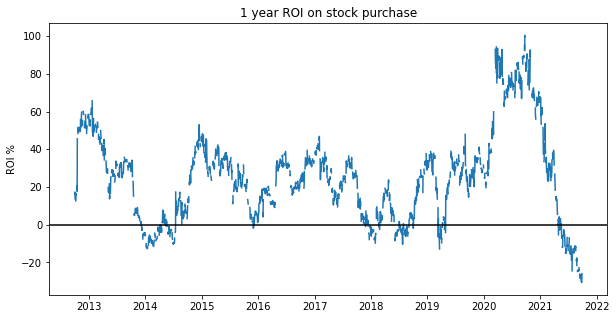

In [17]:
# Look at the one-year ROI for an investment made in each stock on that day

# Calculate one-year ROI for each day
# 1yr ROI = 100% * (price 1yr later - initial purchase price)/(initial stock purchase price)
roi_GOOG = 100 * ((stockdata['GOOG']['close'].shift(-365,freq='D')-(stockdata['GOOG']['close'])) / 
                        (stockdata['GOOG']['close']))
    
plt.figure(figsize=(10,5))

plt.plot(roi_GOOG)

plt.title('1 year ROI on stock purchase')
plt.ylabel('ROI %') 
plt.axhline(color='black')
plt.show()

### Decompose the time series
A time series can be broken down into a set of components using either the additive or the multiplicative model.

An **additive model** is a linear model in which the components are added together.  The model assumes that seasonality is linear and therefore has the same frequency and amplitude over time.  
`y(t) = Trend + Seasonality + Noise`

A **multiplicative model** suggests the components are multiplied together and is therefore nonlinear.  The model assumes that seasonality is nonlinear and frequency and/or amplitude increase or decrease over time  
`y(t) = Trend * Seasonality * Noise`

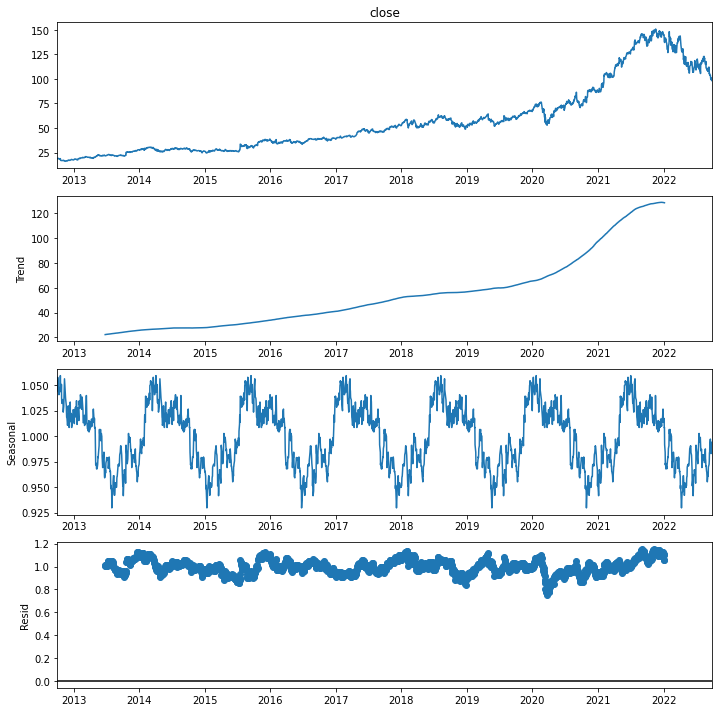

In [12]:
import statsmodels.api as sm
decomposition = sm.tsa.seasonal_decompose(stockdata['GOOG']['close'], model = 'multiplicative',period=365)
plt.rcParams['figure.figsize'] = [10,10]
decomposition.plot()
plt.show()